# Resolución de examen Introducción a IA 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))

### Ejercicio 2

Pre-procesamiento del dataset

a) Obtener el dataset desde el siguiente link. La primera columna representa los datos de entrada y la segunda columna representa los datos de salida.

In [2]:
DATASET_FILENAME = "data/clase_8_dataset.csv"

b) Levantar el dataset en un arreglo de Numpy. 


In [3]:
class Data(object):
    
    def split(self, percentage=0.8):
        return NotImplemented
    
class DataXY(Data):        
    def __init__(self, path, skip_header=True,delimiter=','):
        self.dataset = self._build_dataset(path,skip_header,delimiter)     
        
    def get(self):
        return self.dataset
    
    def split(self, percentage=0.8):
        """ Particiona un dataset y devuelve las dos partes
        """
        dataset_sz = self.dataset.shape[0]
        i0 = int(dataset_sz*percentage)
        indices = np.random.permutation(dataset_sz)
        training_idx, validation_idx = indices[0:i0], indices[i0:]
        return self.dataset[training_idx], self.dataset[validation_idx]
    
    def _build_dataset(self,path,skip_header,delimiter):
        return np.genfromtxt(path, skip_header=skip_header, delimiter=delimiter)  

In [4]:
dataset = DataXY(DATASET_FILENAME)
data = dataset.get()
data.shape

(499, 2)

c) Graficar el dataset de manera tal que sea posible visualizar la nube de puntos.

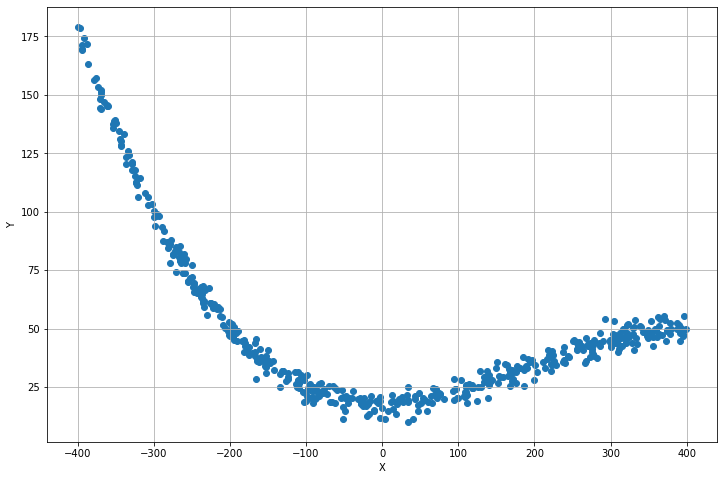

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(data[:,0],data[:,1])
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(which="Both")

d) Partir el dataset en train (80%) y test (20%).

In [6]:
ds_train, ds_test = dataset.split()
ds_train.shape, ds_test.shape

((399, 2), (100, 2))

### Ejercicio 3

Utilizar regresión polinómica para hacer “fit” sobre la nube de puntos del train. Para este ejercicio, se desea utilizar la fórmula cerrada de la optimización polinómica. El modelo es de la forma $y = [W_n ... W_0]  [X^n    X^{n-1} ... 1]$. 

In [7]:
class BaseModel(object):

    def __init__(self):
        self.model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented
    
class LinearRegression(BaseModel):

    def fit(self, X, y):
        if len(X.shape) == 1:
            W = X.T.dot(y) / X.T.dot(X)
        else:
            W = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.model = W
        
    def get_model(self):
        return self.model

    def predict(self, X):
        return self.model * X
    
    def predict_n_coeff(self,X,coeff):
        y_hat = 0
        for c in range(coeff):
            y_hat += w[c]*X**(coeff-c)
        return y_hat

In [8]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

a) Para n = 1 (modelo lineal con ordenada al origen), hacer un fit del modelo utilizando K-FOLDS. Para K-FOLDS partir el train dataset en 5 partes iguales, utilizar 4/5 para entrenar y 1/5 para validar. Informar el mejor modelo obtenido y el criterio utilizado para elegir dicho modelo (dejar comentarios en el código).

In [9]:
def k_folds(X_train, y_train, k=5):

    error = MSE()

    chunk_size = int(len(X_train) / k)
    mse_list = []
    models_list = []
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        regression = LinearRegression()
        regression.fit(new_X_train, new_y_train )
        w = regression.get_model()
        if X_train.ndim > 1:
            prediction = 0
            coeff = X_train.shape[1]
            for c in range(coeff):
                prediction += w[c]*new_X_valid**(coeff-c)   
        else:
            prediction = regression.predict(new_X_valid)
        
        mse_list.append(error(new_y_valid, prediction))
        models_list.append(w)

    return mse_list,models_list

In [10]:
X_train = ds_train[:,0]
y_train = ds_train[:,1]
X_test = ds_test[:,0]
y_test = ds_test[:,1]

In [11]:
mse_list, model_list = k_folds(X_train,y_train)
mse_list

[2961.406492893372,
 3163.9625016329005,
 3111.049347622796,
 3341.193602850409,
 3356.826818658892,
 5604.455329147998]

In [12]:
def get_best_model(mse_list, model_list):
    best_model_idx = np.argmin(mse_list)
    best_mse = np.min(mse_list)
    return best_model_idx, best_mse

In [13]:
best_model_idx, best_mse = get_best_model(mse_list, model_list)
best_model_idx, best_mse

(0, 2961.406492893372)

R: Se elije el modelo que minimiza el error cuadrático medio en el 1/5 separado del train set para validar. 

In [14]:
w = model_list[best_model_idx]
w

-0.0906927372146787

Nota: Se guarda el modelo para ser usado en un ejercicio posterior.

In [15]:
model_3a = w # usado más adelante

b) Repetir el punto (a), para n = {2,3,4}. Computar el error de validación y test del mejor modelo para cada n.

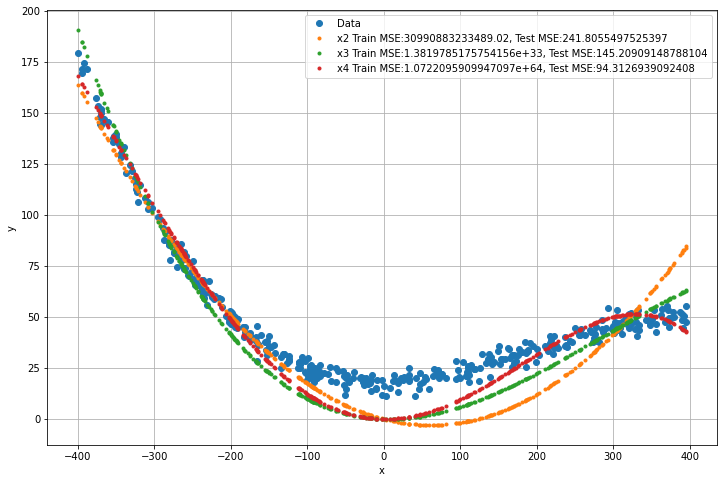

In [16]:
model_results = []
x = X_train
y = y_train

coeffs = [2,3,4]
x_coeffs = []
y_hat_coeffs = []
for coeff in coeffs:
    
    x_acc = []
    for c in range(coeff):
        x_acc.append(x**(coeff-c))
    xx = np.vstack(x_acc).T
        
    mse_list, model_list = k_folds(xx, y.reshape(-1, 1))
    best_model_idx, best_mse = get_best_model(mse_list, model_list)
    w = model_list[best_model_idx]
    
    # Train MSE
    train_mse = best_mse
    
    # Test MSE
    error = MSE()
    y_hat_test = 0
    for c in range(coeff):
        y_hat_test += w[c]*X_test**(coeff-c)   
    test_mse = error(y_test, y_hat_test)
    
    # Sólo para el plot
    y_hat = 0
    for c in range(coeff):
        y_hat += w[c]*X_train**(coeff-c)   

    #y_hat_coeffs.append(y_hat)    
    new_model = {
        "model": w,
        "coeff": coeff,
        "x": x,
        "y": y_hat,
        "legend": f"x{coeff} Train MSE:{train_mse}, Test MSE:{test_mse}",
        "train_mse": train_mse,
        "test_mse": test_mse
    }  
    model_results.append(new_model)

def plot_model_results(x,y,model_results):
    plt.figure(figsize=(12,8))
    plt.plot(x,y,'o')
    legend= ["Data"]
    for m in model_results:
        plt.plot(m["x"],m["y"],'.')
        legend.append(m["legend"])
    plt.grid(which="Both")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(legend)
    plt.show()
    
plot_model_results(x,y,model_results)    

c) Elegir el polinomio que hace mejor fit sobre la nube de puntos y explicar el criterio seleccionado (dejar comentarios en el código). 

In [17]:
for m in model_results:
    print(m["legend"])

x2 Train MSE:30990883233489.02, Test MSE:241.8055497525397
x3 Train MSE:1.3819785175754156e+33, Test MSE:145.20909148788104
x4 Train MSE:1.0722095909947097e+64, Test MSE:94.3126939092408


R: El mejor polinomio es el x4 dado que tiene menor error cuadrático medio en el test_set.

d) Graficar el polinomio obtenido y el dataset de test. 

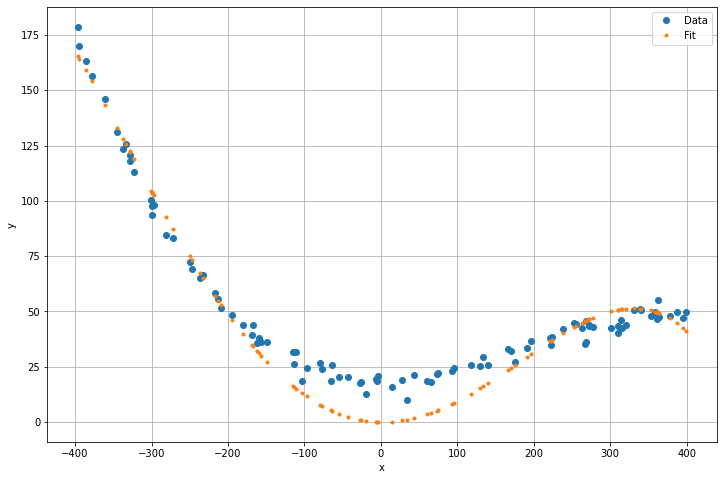

In [18]:
coeff = 4
y_hat_best_test = 0
for c in range(coeff):
    y_hat_best_test += w[c]*X_test**(coeff-c) 
    
plt.figure(figsize=(12,8))
plt.plot(X_test,y_test,'o')
plt.plot(X_test,y_hat_best_test,'.')
plt.grid(which="Both")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Data","Fit"])
plt.show()

### Ejercicio 4

Para el mejor modelo seleccionado en (3c) (el mejor “n”), hacer la optimización utilizando Mini-Batch Gradient Descent (partir el train dataset en 4/5 para entrenar y 1/5 para validar).

- Para la parte de mini-batch no hace falta que use k-fold
- Hagan como se suele hacer en los problema de deep learning
- Tomen el dataset de training
- Cuando arranca la epoch, separen el dataset de training en 4/5 para entrenamiento y 1/5 para validacion
- Hagan la epoch con 4/5 de los datos (vayan acumulando el error de entrenamiento asi pueden calcularle el promedio al terminar la epoch)
- Cuando termina la epoch (pasaron por los 4/5 de los datos de entrenamiento), calculen el error que produce el modelo sobre los datos de validacion.
- Al finalizar la epoch, tienen un error para el entrenamiento y un error para la validacion.
- Hagan esto para todas las epochs.
- Cuando termina el entrenamiento, pueden graficar el error de entrenamiento y el error de validacion en funcion del numero de epoch :sonriente:

In [19]:
coeff = 4
x_acc = []
for c in range(coeff):
    x_acc.append(X_train**(coeff-c))
xx = np.vstack(x_acc).T

In [20]:
def mini_batch_gradient_descent(X_train, y_train, lr=0.0001, amt_epochs=100,batch_size=16):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = batch_size
    m = X_train.shape[1]
    
    mse = MSE()

    # initialize random weights.
    W = np.random.randn(m).reshape(m, 1)
    train_history = []
    test_history = []

    for i in range(amt_epochs):
        
        ### 4/5 Train set Splitting
        dataset_sz = X_train.shape[0]
        i0 = int(dataset_sz*0.8)
        indices = np.random.permutation(dataset_sz)
        training_idx, validation_idx = indices[0:i0], indices[i0:]
        
        X_new_train = X_train[training_idx]
        y_new_train = y_train[training_idx]
        X_new_val = X_train[validation_idx]
        y_new_val = y_train[validation_idx]
        ###
                
        n = X_new_train.shape[0]
        idx = np.random.permutation(X_new_train.shape[0])
        X_new_train = X_new_train[idx]
        y_new_train = y_new_train[idx]
        
        train_error_sum = 0

        batch_size = int(len(X_new_train) / b)
        for i in range(0, len(X_new_train), batch_size):
            end = i + batch_size if i + batch_size <= len(X_new_train) else len(X_new_train)
            batch_X = X_new_train[i: end]
            batch_y = y_new_train[i: end]

            prediction = np.matmul(batch_X, W)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(error * batch_X, axis=0)
            grad_mul = -2/batch_X.shape[0] * grad_sum  # 1xm
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

            W = W - (lr * gradient)
            
            train_error_sum = train_error_sum + mse(prediction,batch_y)
        
        # Train error
        train_error = np.average(train_error_sum)
        
        # Val error
        prediction = np.matmul(X_new_val, W)  # nx1      
        test_error = mse(prediction, y_new_val)
                
        train_history.append(train_error)
        test_history.append(test_error)

    return W, np.array(train_history),np.array(test_history)

a) Para cada epoch, calcular el error de train y el error de validation. 

In [21]:
N_EPOCHS = 300
model, train_history,test_history = mini_batch_gradient_descent(
    xx,y_train.reshape(-1,1), lr=1e-6, amt_epochs=N_EPOCHS)

/home/nhorro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in square
  if sys.path[0] == '':
/home/nhorro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in multiply
/home/nhorro/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/nhorro/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/nhorro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in matmul


>Nota: Es un problema bastante comun en regresion lineal polinomica, porque el error puede ser muy grande muy rapidamente
>Hagan la mejor regresion para n=1
>Asi no luchan tanto con la convergencia, que basicamente es luchar mucho con los parametros

In [22]:
N_EPOCHS = 1000
LEARNING_RATE = 1e-9
BATCH_SIZE = 64
model, train_history,test_history =  mini_batch_gradient_descent(
        X_train.reshape(-1,1),y_train.reshape(-1,1), lr=LEARNING_RATE, amt_epochs=N_EPOCHS, batch_size=BATCH_SIZE)

b) Graficar el error de train y el error de validación en función del número de epoch.

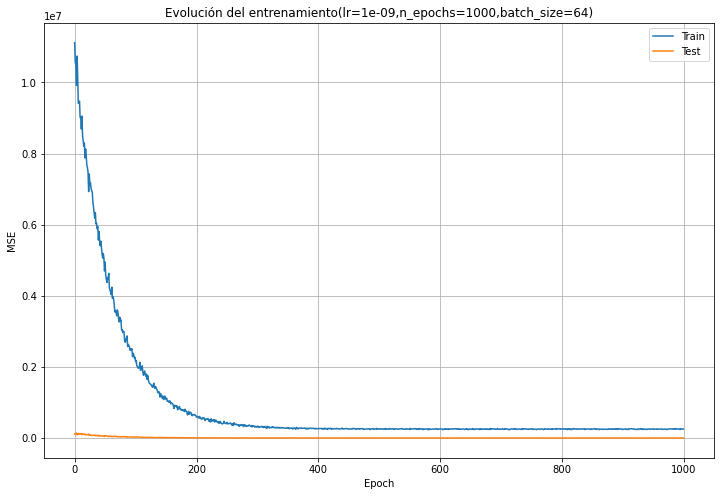

In [23]:
epochs = np.arange(0,N_EPOCHS)
plt.figure(figsize=(12,8))
plt.plot(epochs,train_history)
plt.plot(epochs,test_history)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title( f"Evolución del entrenamiento(lr={LEARNING_RATE},n_epochs={N_EPOCHS},batch_size={BATCH_SIZE})")
plt.grid(which="Both")
plt.legend(["Train","Test"])

c) Comparar los resultados obtenidos para el modelo entrenado con Mini-Batch, contra el modelo obtenido en (3c).

In [24]:
model = model[0][0]

In [25]:
model,model_3a

(-0.0915564139988859, -0.0906927372146787)

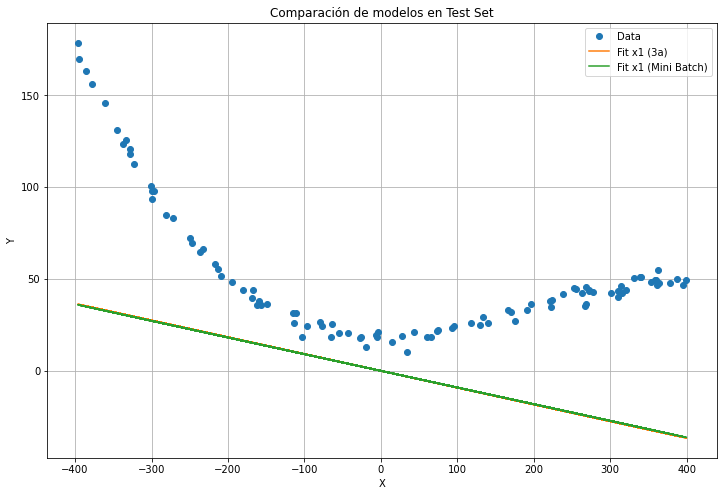

In [26]:
plt.figure(figsize=(12,8))
plt.grid(which="Both")
plt.title("Comparación de modelos en Test Set")
plt.plot(X_test, y_test,'o')
plt.plot(X_test, model*X_test)
plt.plot(X_test, model_3a*X_test)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Data", "Fit x1 (3a)", "Fit x1 (Mini Batch)"])

In [27]:
mse = MSE()
metrics =  [mse(y_test, model_3a*X_test), mse(y_test, model*X_test)]
print("1) MSE x1(3A) en Test Set", metrics[0])
print("2) MSE x1(Mini Batch) en Test Set", metrics[1])

1) MSE x1(3A) en Test Set 3796.1425087146836
2) MSE x1(Mini Batch) en Test Set 3798.806266444816


In [28]:
print("El mejor modelo es:", np.argmin(metrics)+1)

El mejor modelo es: 1


Nota: se guarda para usar más adelante en el ejercicio 5.

In [29]:
best_mse_ex4 = np.min(metrics)
best_mse_ex4

3796.1425087146836

### Ejercicio 5

[EXTRA] Para el mejor modelo seleccionado en (3c), hacer la optimización utilizando Mini-Batch y regularización Ridge.

a) Computar el gradiente de J y codificar en Numpy la implementación del gradiente.

Nota: Se utiliza la misma implementación anterior agregando el parámetro opcional *ridge_param*.

In [30]:
def mini_batch_gradient_descent_ridge(X_train, y_train, lr=0.0001, amt_epochs=100,batch_size=16,ridge_param=None):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
        ridge = Enable ridge regression
    """
    b = batch_size
    m = X_train.shape[1]
    
    mse = MSE()

    # initialize random weights.
    W = np.random.randn(m).reshape(m, 1)
    train_history = []
    test_history = []

    for i in range(amt_epochs):
        
        ### 4/5 Train set Splitting
        dataset_sz = X_train.shape[0]
        i0 = int(dataset_sz*0.8)
        indices = np.random.permutation(dataset_sz)
        training_idx, validation_idx = indices[0:i0], indices[i0:]
        
        X_new_train = X_train[training_idx]
        y_new_train = y_train[training_idx]
        X_new_val = X_train[validation_idx]
        y_new_val = y_train[validation_idx]
        ###
                
        n = X_new_train.shape[0]
        idx = np.random.permutation(X_new_train.shape[0])
        X_new_train = X_new_train[idx]
        y_new_train = y_new_train[idx]
        
        train_error_sum = 0

        batch_size = int(len(X_new_train) / b)
        for i in range(0, len(X_new_train), batch_size):
            end = i + batch_size if i + batch_size <= len(X_new_train) else len(X_new_train)
            batch_X = X_new_train[i: end]
            batch_y = y_new_train[i: end]

            prediction = np.matmul(batch_X, W)  # nx1
            error = batch_y - prediction  # nx1

            # Gradient (sin ridge regularization)
            grad_sum = np.sum(error * batch_X, axis=0)
            grad_mul = -2/batch_X.shape[0] * grad_sum  # 1xm
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1
            
            # Gradient (c/ ridge regularization)
            if ridge_param is not None:
                gradient  = gradient + ( 2.0 * ridge_param)
                        
            W = W - (lr * gradient)
                            
            train_error_sum = train_error_sum + mse(prediction,batch_y)
        
        # Train error
        train_error = np.average(train_error_sum)
        
        # Val error
        prediction = np.matmul(X_new_val, W)  # nx1      
        test_error = mse(prediction, y_new_val)
                
        train_history.append(train_error)
        test_history.append(test_error)

    return W, np.array(train_history),np.array(test_history)

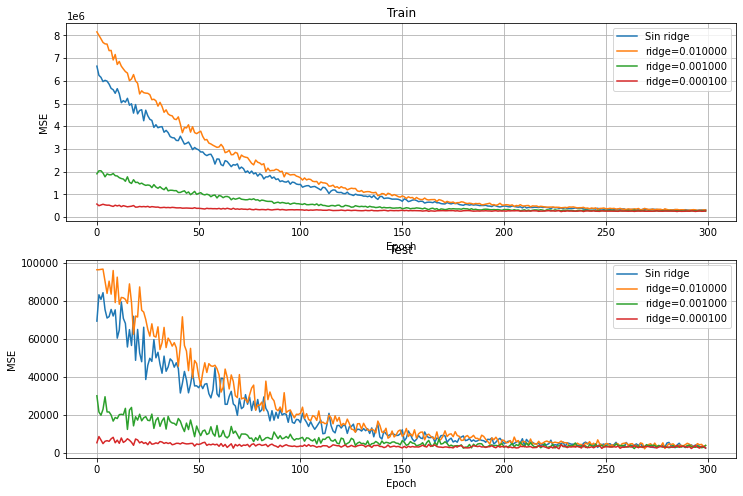

In [31]:
ridge_params_to_test = [None,0.01,0.001,0.0001]
ridge_models = []
N_EPOCHS = 300

fig, axs = plt.subplots(2,1,figsize=(12,8))
plt.title( f"Evolución del entrenamiento(lr={LEARNING_RATE},n_epochs={N_EPOCHS},batch_size={BATCH_SIZE})")
axs[0].set_title("Train")
axs[1].set_title("Test")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("MSE")
axs[0].grid(which="Both")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("MSE")
axs[1].grid(which="Both")
legend = [] 
for ridge_param in ridge_params_to_test:
    model_ridge, train_history,test_history = mini_batch_gradient_descent_ridge(
        X_train.reshape(-1,1),y_train.reshape(-1,1), lr=1e-9, amt_epochs=N_EPOCHS, batch_size=64,ridge_param=ridge_param)
    ridge_models.append({
        "model": model_ridge[0][0],
        "ridge_param": ridge_param,
        "best_mse_train": np.min(train_history),
        "best_mse_test": np.min(test_history)
    })
    epochs = np.arange(0,N_EPOCHS)
    axs[0].plot(epochs,train_history) 
    axs[1].plot(epochs,test_history) 
    if ridge_param is not None:
        legend.append("ridge=%f" %ridge_param )
    else:
        legend.append("Sin ridge")
axs[0].legend( legend )
axs[1].legend( legend )

b) Comparar con el modelo obtenido en (4).

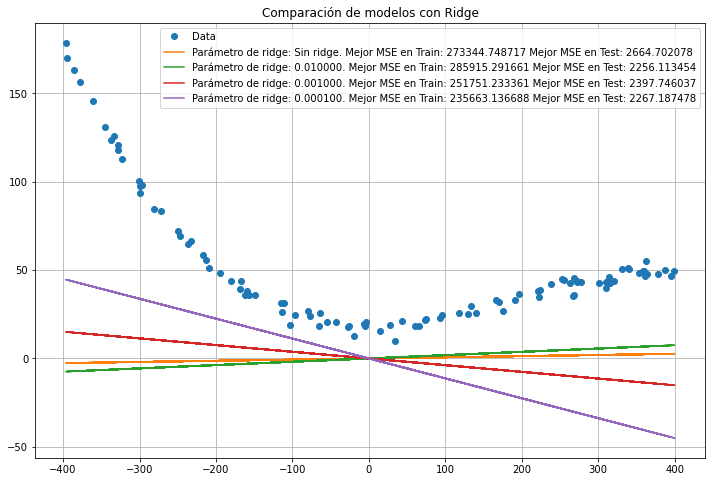

In [32]:
plt.figure(figsize=(12,8))
plt.grid(which="Both")
plt.title("Comparación de modelos con Ridge")
legends = ["Data"]
plt.plot(X_test, y_test,'o')
for m in ridge_models:
    if m["ridge_param"] is None:
        ridge_param = "Sin ridge"
    else:
        ridge_param = "%f" % m["ridge_param"]
        
    legend = "Parámetro de ridge: %s. Mejor MSE en Train: %f Mejor MSE en Test: %f" % ( ridge_param, m["best_mse_train"], m["best_mse_test"] )
        
    plt.plot(X_test, m["model"]*X_test)
    legends.append(legend)
plt.legend(legends)

In [33]:
for m in ridge_models:
    if m["ridge_param"] is None:
        ridge_param = "Sin ridge"
    else:
        ridge_param = "%f" % m["ridge_param"]
    
    print("Parámetro de ridge: %s. Mejor MSE en Train: %f Mejor MSE en Test: %f" % 
          ( ridge_param, m["best_mse_train"], m["best_mse_test"] ))
print("Ejercicio 4 - Mejor MSE: %f" % best_mse_ex4)

Parámetro de ridge: Sin ridge. Mejor MSE en Train: 273344.748717 Mejor MSE en Test: 2664.702078
Parámetro de ridge: 0.010000. Mejor MSE en Train: 285915.291661 Mejor MSE en Test: 2256.113454
Parámetro de ridge: 0.001000. Mejor MSE en Train: 251751.233361 Mejor MSE en Test: 2397.746037
Parámetro de ridge: 0.000100. Mejor MSE en Train: 235663.136688 Mejor MSE en Test: 2267.187478
Ejercicio 4 - Mejor MSE: 3796.142509


Conclusiones:
- Para este modelo el uso de un término regularizador "ridge" puede reducir la cantidad de épocas necesarias para optimizar el modelo.
- Si bien hay diferencias en los MSEs de cada modelo evaluado, son bajas y por lo tanto pueden caer dentro del error numérico como para poder afirmar fehacientemente que un modelo es mejor que otro. Debería repetirse esta prueba con un modelo que haga un mejor fit (ej: el polinomio de grado 4).